# Using `scipy.integrate`

This module will teach you how to integrate in the `astropy` and scientific python environment.

## The Planck function

The Planck function describes how a black-body radiates energy. We will explore how to find bolometric luminosity using the Planck function in both frequency and wavelength space.

In [1]:
import numpy as np
from scipy import integrate
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu, BlackBody1D
from astropy import units as u, constants as c
import matplotlib.pyplot as plt

Let's say we have a black-body at 5000 Kelvin. We can find out the total power output from this object, but integrating the Planck function. The simplest way to do this is by approximating the integral using the trapezoid rule. Let's do this first using the frequency definition of the Planck function.

We will define a photon frequency grid, and evaluate the Planck function at those frequencies. Those will be used to numerically integrate.

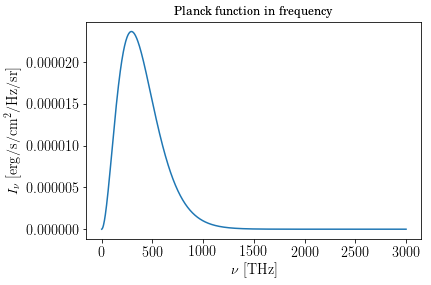

In [2]:
nu = np.linspace(1., 3000., 1000) * u.THz
bb5000K_nu = blackbody_nu(in_x=nu, temperature=5000. * u.Kelvin)
plt.plot(nu, bb5000K_nu)
plt.xlabel(r'$\nu ~ [{\rm THz}]$')
plt.ylabel(r'$I_{\nu} ~ [{\rm erg/s/cm^2/Hz/sr}]$')
plt.title('Planck function in frequency')
plt.show()

In [3]:
np.trapz(x=nu, y=bb5000K_nu).to('erg/s/cm2/sr')

<Quantity 11280833528.711555 erg / (cm2 s sr)>

Now we can do something similar, but for a wavelength grid. We want to integrate over an equivalent wavelength range to the frequency range we did earlier. We can transform the maximum frequency into the corresponding (minimum) wavelength by using the `.to()` method, with the addition of an *equivalency*.

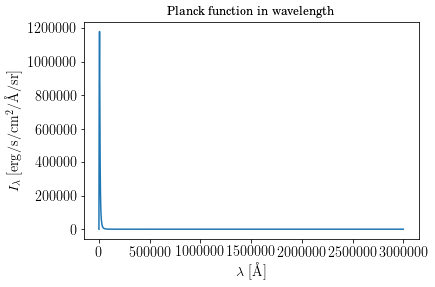

In [4]:
lam = np.linspace(nu.max().to(u.AA, equivalencies=u.spectral()),
                  nu.min().to(u.AA, equivalencies=u.spectral()), 1000)
bb5000K_lam = blackbody_lambda(in_x=lam, temperature=5000. * u.Kelvin)
plt.plot(lam, bb5000K_lam)
plt.xlabel(r'$\lambda ~ [{\rm \AA}]$')
plt.ylabel(r'$I_{\lambda} ~ [{\rm erg/s/cm^2/\AA/sr}]$')
plt.title('Planck function in wavelength')
plt.show()

In [10]:
np.trapz(x=lam, y=bb5000K_lam).to('erg/s/cm2/sr')

<Quantity 11467744400.928753 erg / (cm2 s sr)>

## The stellar initial mass function (IMF)

The stellar initial mass function tells us how many of each mass of stars are formed. In particular, low-mass stars are much more abundant than high-mass stars are. Let's explore more of the functionality of `astropy` using this concept.

Normally, people think of the IMF as a power-law probability density function. Let's write a little class to help us keep track of that...

In [11]:
class PowerLawPDF(object):
    def __init__(self, gamma, B=1.):
        self.gamma = gamma
        self.B = B
    def __call__(self, x):
        return x**gamma / self.B

Now we can 

## Challenge problems

* Try to derive a relationship between recent star-formation rate and $H\alpha$ flux. How does this depend on the slope and endpoints of the IMF?
 * **this needs more fleshing out, a few resources to look at**